# Project 2: Reproducibility in Natural Language Processing

## Part 2: Simple Text Processing - Tokenization, Lemmatization, Word Frequency, Vectorization (20 pts)

### Set-Up

This notebook walks through simple text processing and analysis using the `SpaCy` package on the `SOTU.csv` file. The data file is structured as a CSV with columns for president name, speech text, year, and word count in the speech. The package should already be included in the `environment.yml`. However, we will also need to download `en_core_web_sm`, an English language text processing model. To do this, while having your `sotu` environment activated, run the following:

```
python -m spacy download en_core_web_sm
```

Some important definitions:

- *Token*: a single word or piece of a word
- *Lemma*: the core component of a word, e.g., "complete" is the lemma for "completed" and "completely"
- *Stop Word*: a common word that does not add semantic value, such as "a", "and", "the", etc.
- *Vectorization*: representing a document as a vector where each index in the vector corresponds to a token or word and each entry is the count.

We will explore the most common tokens and lemmas throughout different slices of the speech data. We will also develop vectorization representations of the speeches. 

 The core steps are:

1. Process speeches using the SpaCy nlp module
2. Analyze Tokens vs Lemmas:
- Create a list of all tokens across all speeches that are not stop words, punctuation, or spaces.
- Create a second list of the lemmas for these same tokens.
- Display the top 25 for each of these and compare.
3. Analyze common word distributions over different years:
- Create a function that takes the dataset and a year as an input and outputs the top n lemmas for that year's speeches
- Compare the top 10 words for 2023 versus 2019
4. Document Vectorization:
- Train a Term Frequency-Inverse Document Frequency (TF-IDF) vectorization model using your processed dataset and scikit learn
- Output the feature vectors 

**Helpful Resources:**
- https://realpython.com/natural-language-processing-spacy-python/
- https://www.statology.org/text-preprocessing-feature-engineering-spacy/ 
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html# 
- https://www.geeksforgeeks.org/nlp/how-to-store-a-tfidfvectorizer-for-future-use-in-scikit-learn/ 



### Processing Speeches with SpaCy

In [1]:
# imports
import spacy
from tqdm import tqdm
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-dark') 

### Read in the data and Download en_core_web_sm (English language text processing model)

In [2]:
sou = pd.read_csv("data/SOTU.csv")
nlp = spacy.load("en_core_web_sm")

### Examining the speeches from 2000 and onwards

In [3]:
# subset the speech dataframe for speeches from 2000 and onwards
sou_2000 = sou[sou["Year"] >= 2000]
sou_2000.head()

,President,Year,Text,Word Count
0,Joseph R. Biden,2024.0,"\n[Before speaking, the President presented hi...",8003
1,Joseph R. Biden,2023.0,\nThe President. Mr. Speaker——\n[At this point...,8978
2,Joseph R. Biden,2022.0,"\nThe President. Thank you all very, very much...",7539
3,Joseph R. Biden,2021.0,\nThe President. Thank you. Thank you. Thank y...,7734
4,Donald J. Trump,2020.0,\nThe President. Thank you very much. Thank yo...,6169


### Processing speeches using the nlp function

In [4]:
# Process each speeches using the 'nlp' function
# should take about 30 seconds to process
tokens_lst = []
speeches = sou_2000["Text"]
for speech in tqdm(speeches):
    tokens_lst.append(nlp(speech))

100%|██████████| 25/25 [00:25<00:00,  1.03s/it]


### Analyze Tokens vs Lemmas

#### Token List

Obtains a list of lowercase tokens across all speeches that are not spaces, stopwords, or punctuation. Examine the top 20 tokens.

In [5]:
tokens_filt = []
for tokens in tqdm(tokens_lst):
    for token in tokens:
        if not token.is_stop and not token.is_punct and not token.is_space:
            tokens_filt.append(token.lower_)

100%|██████████| 25/25 [00:00<00:00, 357.14it/s]


In [6]:
# print top 20 tokens
token_counts = Counter(tokens_filt)
top_20_tokens = token_counts.most_common(20)
top_20_tokens

[('america', 816),
 ('people', 637),
 ('american', 582),
 ('new', 530),
 ('years', 439),
 ('americans', 437),
 ('world', 425),
 ('year', 406),
 ('country', 369),
 ('jobs', 348),
 ('tonight', 344),
 ('work', 324),
 ('know', 323),
 ('let', 320),
 ('congress', 317),
 ('nation', 311),
 ('time', 301),
 ('help', 282),
 ('need', 266),
 ('tax', 255)]

#### Lemma List

Obtains a list of lowercase lemmas across all speeches that are not spaces, stopwords, or punctuation. Examine the top 20 lemmas.

In [7]:
lemmas = []
for tokens in tqdm(tokens_lst):
    for token in tokens:
        if not token.is_stop and not token.is_punct and not token.is_space:
            lemmas.append(token.lemma_.lower())

lemma_counts = Counter(lemmas)
top_20_lemmas = lemma_counts.most_common(20)
top_20_lemmas

100%|██████████| 25/25 [00:00<00:00, 334.07it/s]


[('year', 845),
 ('america', 816),
 ('people', 639),
 ('american', 587),
 ('work', 557),
 ('new', 532),
 ('job', 486),
 ('country', 435),
 ('americans', 432),
 ('world', 426),
 ('know', 395),
 ('nation', 388),
 ('help', 378),
 ('need', 353),
 ('time', 351),
 ('tonight', 344),
 ('child', 332),
 ('let', 326),
 ('congress', 317),
 ('come', 301)]

#### Token versus Lemma Comparison

**There are some words that are the same/similar in the top tokens vs the top lemmas, however we see a shift in ordering. For example, "year" becomes the top of the list for lemmas appearing 845 times while "years" is fifth of the list for tokens appearing 439 times. This makes sense as the lemma for "years" is "year" plus the existence of additional tokens that have "year" as its key component. The lemma "child" on the other hand appears in the top lemma list but not in the token list, showing that this lemma is more prevalent across speeches.**

### Common Words

#### Common Words per Year Function

This function obtains the n-most common words in speeches for a given year.

inputs: 
- df raw unprocessed sou dataframe
- year
- n

outputs:
- top n words for that years


In [8]:
def get_most_common_words(df, year, n=25):
    """
    Processes the SOTU speech for a given year and returns
    the most common non-stopword/punctuation lemmas.
    """

    # Step 1: Subset df
    df_year = df[df["Year"] == year]
    
    # Step 2: Process the text with spaCy
    speeches = df_year["Text"]
    lemmas = []
    for speech in tqdm(speeches):
        tokens = nlp(speech) #get tokens
        for token in tokens:
            if not token.is_stop and not token.is_punct and not token.is_space:
                lemmas.append(token.lemma_.lower())
                
    # Step 3: Get lemmas
    lemma_counts = Counter(lemmas)
    top_n_lemmas = lemma_counts.most_common(n)  
    
    return top_n_lemmas

In [9]:
# test on 2024
get_most_common_words(sou, 2024, n=10)

100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


[('president', 58),
 ('year', 45),
 ('america', 44),
 ('american', 34),
 ('people', 33),
 ('$', 33),
 ('member', 32),
 ('want', 29),
 ('audience', 29),
 ('know', 29)]

#### Compare 2023 to 2017

Comparing the top 20 words for 2017 and 2023, and plotting the words and their frequencies in a barchart.

In [10]:
words_2023 = get_most_common_words(sou, 2023, n=20)
words_2017 = get_most_common_words(sou, 2017, n=20)

100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


In [11]:
words_2023

[('year', 58),
 ('go', 56),
 ('let', 45),
 ('know', 40),
 ('people', 39),
 ('job', 38),
 ('america', 36),
 ('come', 33),
 ('law', 33),
 ('pay', 33),
 ('american', 31),
 ('$', 31),
 ('president', 30),
 ('look', 27),
 ('world', 25),
 ('folk', 24),
 ('nation', 24),
 ('audience', 23),
 ('work', 23),
 ('right', 23)]

In [12]:
words_2017

[('american', 34),
 ('america', 29),
 ('country', 26),
 ('nation', 21),
 ('great', 20),
 ('new', 19),
 ('year', 19),
 ('world', 18),
 ('job', 15),
 ('people', 15),
 ('americans', 14),
 ('united', 13),
 ('tonight', 13),
 ('states', 12),
 ('work', 12),
 ('child', 12),
 ('want', 12),
 ('time', 12),
 ('citizen', 11),
 ('right', 11)]

In [13]:
# putting the words and counts into a pd Dataframe for better structure
# and to make plotting easier
df_2017 = pd.DataFrame(words_2017, columns=["Word", "Count"])
df_2023 = pd.DataFrame(words_2023, columns=["Word", "Count"])

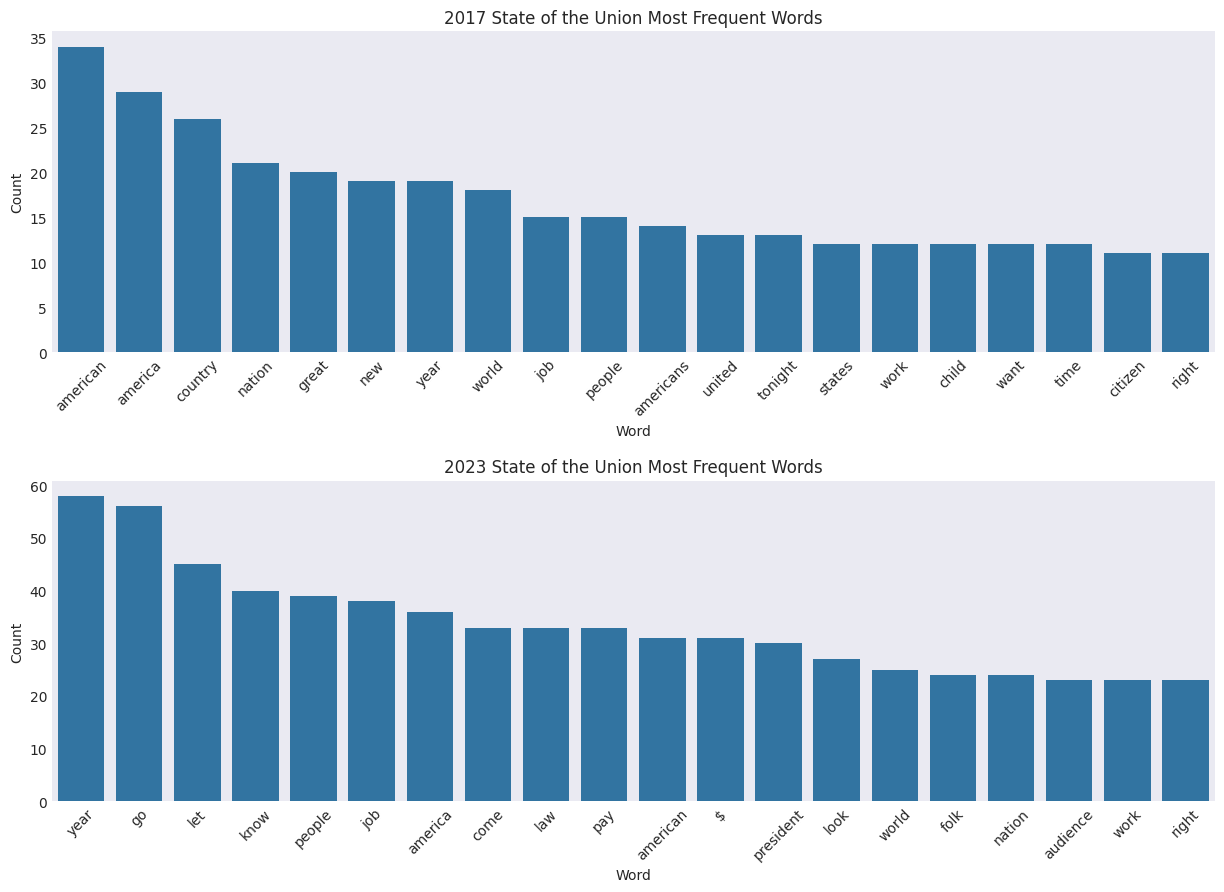

In [14]:
# using seaborn, subplots, and rotate tick labels
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(nrows=2, figsize=(15, 10))

sns.barplot(df_2017, x="Word", y="Count", ax=axs[0])
axs[0].tick_params(axis='x', labelrotation=45)
axs[0].set_xlabel("Word") 
axs[0].set_title("2017 State of the Union Most Frequent Words")

sns.barplot(df_2023, x="Word", y="Count", ax=axs[1])
axs[1].tick_params(axis='x', labelrotation=45)
axs[1].set_xlabel("Word") 
axs[1].set_title("2023 State of the Union Most Frequent Words")

plt.subplots_adjust(hspace=0.4)
plt.savefig("outputs/topwords_2017_vs_2023.png", dpi=100, bbox_inches="tight")
plt.show()

## Observations

**The most common words for 2017 included the words american, america, country, nation, great, etc. which makes sense as Donald Trump was the president at the time and his slogan was "Make America Great Again". The most common words are a lot different in 2023 when Joe Biden was in office using more words like year, go, let, know, people, job etc. and his campaign centered around the slogan "Finish the job."**

### TF-IDF Vectorization

To use statsitical alorithms on documents, I need to transform them into vectors, where each element of the vector corresponds to a particular word in a document or corpus of documents. One common way is via TF-IDF embeddings. LLMs work similarly - they typically use transformer models to generate text embeddings before sending text through a deep neural network. 

Here I will fit a TF-IDF vectorizer, plot all the speeches on a 2-D grid using PCA and also using a heatmap, and examine TF-IDF scores for the top 10 most common words in the first speech. This is a good resource here: https://medium.com/GeoffreyGordonAshbrook/vector-visualization-2d-plot-your-tf-idf-with-pca-83fa9fccb1d 

In [15]:
#import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

#### Train the Vectorizer and Transform the Data

In [16]:
# use this as input to fit the TF-IDF vectorizer
raw_docs = sou["Text"].to_list()

In [17]:
# use fit_transform for vectorizer and PCA
tfidf_model = TfidfVectorizer()
tfidf_vectors = tfidf_model.fit_transform(raw_documents=raw_docs).toarray()
tfidf_vectors

array([[0.        , 0.02195892, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02771479, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01640109, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(246, 25957))

The output of `fit_transform()` will be a matrix where each row corresponds to a speech, each column corresponds to a word in the corpus of speeches, and the value is the TF-IDF score which measures the importance of that word in that speech, relative to the rest of the speeches.

#### Plot Speeches

- First used PCA to generate the first chart
- Second use seaborn heatmap with a log-scaled color axis to generate the second chart

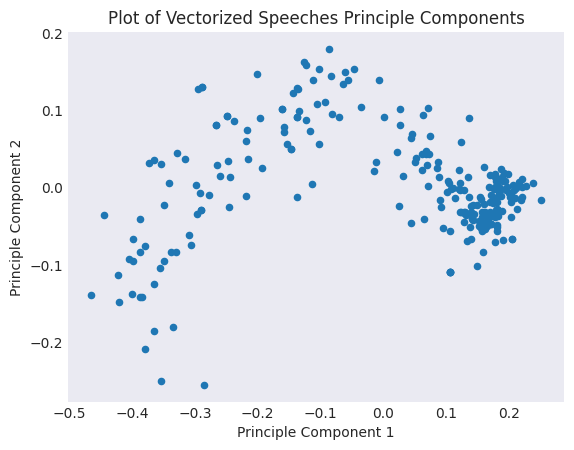

In [18]:
# Step 1: Set PCA to find first 2 principal components
pca = PCA(n_components=2)

# Step 2: Create a new dataframe where each row is a speech, and each column is a projection onto
# one of the two principal components
df2d = pd.DataFrame(pca.fit_transform(tfidf_vectors), columns=["Principle Component 1", "Principle Component 2"])

# Plot Data Visualization (Matplotlib)
df2d.plot(kind='scatter', x='Principle Component 1', y='Principle Component 2')
plt.title("Plot of Vectorized Speeches Principle Components")

plt.savefig("outputs/pca_vectorized_speeches.png", dpi=100, bbox_inches="tight")
plt.show()

### Observation
**The PCA plot shows how the speeches relate to each other, with points closer together representing more similar speeches. The cluster on the right indicate speeches that have similar style or topic, while the other points have more variation spread across. The outliers may represent speeches with unique vocabulary.**

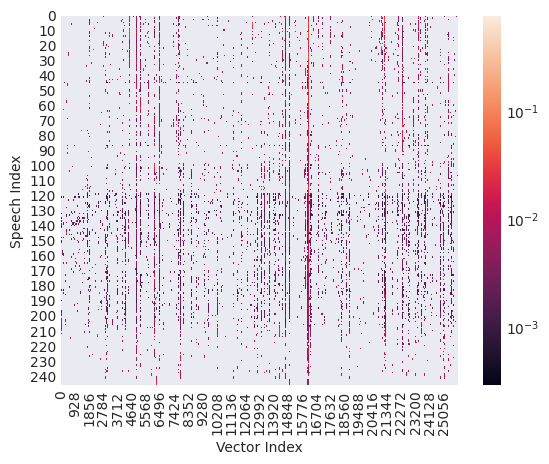

In [19]:
# Hint - vectorized_docs is a sparse matrix whose rows are speeches and columns are tokens, with each
# value being a TF-IDF score. Densify this array first, and then plot using seaborn.
import matplotlib.colors as mcolors
sns.heatmap(tfidf_vectors, norm=mcolors.LogNorm())
plt.xlabel("Vector Index")
plt.ylabel("Speech Index")

plt.savefig("outputs/tfidf_heatmap.png", dpi=100, bbox_inches="tight")
plt.show()

### Observation
**The TF-IDF heatmap shows how the words contributes to each speech, with darker spots meaning higher importance. The vertical bands mean some words appear across many speeches, while the scattered darker points within rows highlight words that are more unique to specific speeches.**

#### The TF-IDF value for certain words and documents

In [20]:
word_list = ['year',
 'america',
 'people',
 'american',
 'work',
 'new',
 'job',
 'country',
 'americans',
 'world'] # top ten most common words through whole corpus

### Obtaining the words index numbers, their IDF scores, and their TF-IDF scores

In [21]:
word_nums = [tfidf_model.vocabulary_[word] for word in word_list] # get each word's index number using the .vocabular_ attributed of vectorizer

In [22]:
idf_score = [tfidf_model.idf_[index] for index in word_nums] # get their IDF score by using .idf_ at the indices from the previous step

In [23]:
tf_idf = [tfidf_vectors[0, index] for index in word_nums] # get the tf_idf score for the first speech

In [24]:
pd.DataFrame({"Word": word_list, "IDF Score": idf_score, "TF-IDF Score": tf_idf})

,Word,IDF Score,TF-IDF Score
0,year,1.032925,0.022719
1,america,1.272946,0.068439
2,people,1.037118,0.043087
3,american,1.102217,0.045792
4,work,1.162281,0.005681
5,new,1.024591,0.016275
6,job,2.043480,0.009988
7,country,1.008130,0.013550
8,americans,1.713598,0.041877
9,world,1.138750,0.026438


### Observations
**The IDF scores show which words are more rare across all speeches, with “job” and “americans” being the most rare. The TF-IDF scores show which words matter most in particular speeches, such as the words america, american, americans, and people.**
